In [1]:
import os, math, numpy as np
import pandas as pd
import copy
from collections import defaultdict
from docplex.mp.model import Model

In [2]:
### Calculate travel time between two points: origin and destination
def travel_time(origin_id,destination_id,meters_per_minute,locations):
    dist=np.sqrt((locations.at[destination_id,'x']-locations.at[origin_id,'x'])**2\
                +(locations.at[destination_id,'y']-locations.at[origin_id,'y'])**2)
    tt=np.ceil(dist/meters_per_minute)
    return tt

#### Function that reads in data instance
A folder of data instance has 5 files: (1) couriers.txt, (2) instance_characteristics.txt, (3) instance_parameters.txt, (4) orders.txt, (5) restaurants.txt

In [3]:
# Read instance information
def read_instance_information(instance_dir):
    orders=pd.read_table(os.path.join(instance_dir,'orders.txt'))
    restaurants=pd.read_table(os.path.join(instance_dir,'restaurants.txt'))
    couriers=pd.read_table(os.path.join(instance_dir,'couriers.txt'))
    instanceparams=pd.read_table(os.path.join(instance_dir,'instance_parameters.txt'))

    order_locations=pd.DataFrame(data=[orders.order,orders.x,orders.y]).transpose()
    order_locations.columns=['id','x','y']
    restaurant_locations=pd.DataFrame(data=[restaurants.restaurant,restaurants.x,restaurants.y]).transpose()
    restaurant_locations.columns=['id','x','y']
    courier_locations=pd.DataFrame(data=[couriers.courier,couriers.x,couriers.y]).transpose()
    courier_locations.columns=['id','x','y']
    locations=pd.concat([order_locations,restaurant_locations,courier_locations])
    locations.set_index('id',inplace=True)

    meters_per_minute=instanceparams.at[0,'meters_per_minute']
    pickup_service_minutes=instanceparams.at[0,'pickup service minutes']
    dropoff_service_minutes=instanceparams.at[0,'dropoff service minutes']
    target_click_to_door=instanceparams.at[0,'target click-to-door']
    pay_per_order=instanceparams.at[0,'pay per order']
    guaranteed_pay_per_hour=instanceparams.at[0,'guaranteed pay per hour']

    return orders,restaurants,couriers,instanceparams,locations, meters_per_minute, pickup_service_minutes, dropoff_service_minutes, \
            target_click_to_door, pay_per_order,\
            guaranteed_pay_per_hour

# Set hyper-parameters:
f∶ every f minutes solves a matching problem to prescribe the next pick-up and delivery assignment for each courier<br>
t : optimization time<br>
∆_(u): t+ ∆_(u ) is the assignment horizon and to determine Z_(t)<br>
beta: control the freshness in the construction of bundles
gamma: control the click to door time in the construction of bundles


In [12]:
# Accorting to default values in the paper
f = 5
delta_u = 10
# Not find in the paper
beta = 10 # should be tuned
gamma = 10 # should be tuned
X = 40 # max pickup delay for commitment strategy, should be tuned

# Defining objects

**Order Object**

In [5]:
class Order:
    def __init__(self, order_information : dict):

        self.id = order_information.get('order')
        self.destination = (order_information.get('x'), order_information.get('y'))
        self.placement_time = order_information.get('placement_time')
        self.restaurant_id = order_information.get('restaurant')
        self.ready_time = order_information.get('ready_time')
        
        # To be updated after assignment
        self.pickup_time = 0
        self.dropoff_time = 0
        self.courier_id = ""

**Route object**<br>
A route is a bundle,i.e: a list of ordered orders

In [11]:
class Route(object):
    def __init__(self,bundle : list, restaurant_id : str): 
        self.bundle = bundle 
        self.restaurant_id = restaurant_id
        
        # Hyperparameters
        self.beta = beta
        self.gamma = gamma
        
    def get_ready_time(self):
        ready_time = max([o.ready_time for o in self.bundle])
        return ready_time

    # calculate total travel time from 1st destination to the last destination of the route
    # do not include pickup service time and drop off service time
    def get_total_travel_time(self,meters_per_minute,locations):
        travel_points = [self.restaurant_id]+ [o.id for o in self.bundle]
        if len(travel_points) == 1:
            return 0
        else:
            total_travel_time = 0
            for i in range(len(travel_points)-1):
                total_travel_time += travel_time(travel_points[i], travel_points[i+1],meters_per_minute,locations)
            return total_travel_time

    def get_end_position(self,meters_per_minute,locations):
        return self.bundle[-1].id

    # calculate total service delay 
    # service delay = arrival_time at customer place - ready time (ignoring pickup service time and dropoff service time)
    def get_total_service_delay(self,meters_per_minute,locations):
        travel_points = [self.restaurant_id]+ [o.id for o in self.bundle]
        if len(travel_points) == 1:
            return 0
        else:
            total_service_delay = 0
            arrival_time_at_cp = self.get_ready_time()
            for i in range(len(travel_points)-1):
                arrival_time_at_cp += (travel_time(travel_points[i], travel_points[i+1],meters_per_minute,locations))
                total_service_delay += (arrival_time_at_cp - self.bundle[i].ready_time)
            return total_service_delay

    # calculate total_click_to_door 
    # click_to_door = arrival_time at customer place - placement time (ignoring pickup service time and dropoff service time)
    # the below function implement 
    def get_total_service_waiting(self,meters_per_minute,locations):
        travel_points = [self.restaurant_id]+[o.id for o in self.bundle]
        if len(travel_points) == 1:
            return 0
        else:
            total_service_waiting = 0
            arrival_time_at_cp = self.get_ready_time()
            for i in range(len(travel_points)-1):
                arrival_time_at_cp += (travel_time(travel_points[i], travel_points[i+1],meters_per_minute,locations))
                total_service_waiting += (arrival_time_at_cp - self.bundle[i].placement_time)
            return total_service_waiting

    # calculate route efficiency: travel time per order:
    def route_efficiency(self,meters_per_minute,locations):
        return len(self.bundle) / self.get_total_travel_time(meters_per_minute,locations)

    # calculate route cost
    def get_route_cost(self,meters_per_minute,locations):
        route_cost = self.get_total_travel_time(meters_per_minute,locations) + self.beta * self.get_total_service_delay(meters_per_minute,locations) + self.gamma * self.get_total_service_waiting(meters_per_minute,locations)
        return route_cost


**Assignment Object**

In [13]:
class Assignment():
    def __init__(self, assign_time : int , restaurant_id : str, courier: object, route : Route):
        self.assign_time = assign_time
        self.restaurant_id = restaurant_id  # each assignment of a bundle has only one corresponding restaurant
        self.pickup_time = 0
        self.courier = courier
        self.route = route
        self.isfinal_flag = 0 # indicate if the assignment is final (can not be updated)
        self.update_time = 0

    def update(self, new_assignment, meters_per_minute,locations):
        # update the new assignment into the old assignment
        # combine orders in the new assigment with orders in the old assignment
        for o in new_assignment.route.bundle:
            n = len(self.route.bundle)
            min_route_cost = float('inf')
            best_pos = 0
            for pos in range(n+1):
                self.route.bundle.insert(pos,o)
                route_cost = self.route.get_route_cost(meters_per_minute,locations)
                if route_cost < min_route_cost:
                    min_route_cost = route_cost
                    best_pos = pos
                self.route.bundle.pop(pos)
            self.route.bundle.insert(best_pos, o)
        # if the new assigment is final (isfinal_flage = 1), set isfinal_flag of the combination as 1
        if new_assignment.isfinal_flag == 1:
            self.isfinal_flag = 1
        else: # if the new assigment is not final (isfinal_flage = 0)
            # if there is an order that has been ready for x minutes, set assignment as final
            if not self.is_no_order_long_ready_time():
                self.isfinal_flag = 1
            else: # if there is no order that has been ready for x minutes, set assignment as tentative
                self.isfinal_flag = 0
        self.update_time +=1
        self.assign_time = new_assignment.assign_time

    def is_no_order_long_ready_time(self, x = X) -> bool:
        for o in self.route.bundle:
            route_ready_time = self.route.get_ready_time()
            if route_ready_time - o.ready_time >= x:
                return False
        return True

**Courier Object**

In [8]:
class Courier(object):
    def __init__(self, courier_information : dict, ):
        self.id = courier_information.get('courier')
        self.x = courier_information.get('x')
        self.y = courier_information.get('y')
        self.on_time = courier_information.get('on_time')
        self.off_time = courier_information.get('off_time')

        # Sequence of moves of the courier
        # Update and derived along the way
        self.assignments = []                           # containing assigned assigments 
        self.next_available_time = self.on_time                 # when the courier is available for the next assignment (or the drop off time of the last order of the last assignment)
        self.position_after_last_assignment = self.id  # the position of the courier after completing the last assignment           

**DeliveryRouting Object**

In [9]:
class DeliveryRouting:
    def __init__(self, instance_dir : str):

        orders, restaurants, couriers, instanceparams, locations ,\
        self.meters_per_minute, self.pickup_service_minutes, self.dropoff_service_minutes, \
            self.target_click_to_door, self.pay_per_order,\
            self.guaranteed_pay_per_hour = read_instance_information(instance_dir)


        self.orders = [Order(order) for order in orders.to_dict(orient = 'records')]
        self.orders = sorted(self.orders, key = lambda x: x.id)

        self.restaurants = restaurants
        self.couriers = [Courier(courier) for courier in couriers.to_dict(orient = 'records')]
        self.unassigned_orders = self.copy(self.orders)
        
        self.orders_by_horizon_interval = defaultdict(list)
        self.locations = locations

        # Hyperparameters
        self.f = 5
        self.delta_u = 10


    def travel_time(self, origin_id,destination_id):
        dist=np.sqrt((self.locations.at[destination_id,'x']-self.locations.at[origin_id,'x'])**2\
                    +(self.locations.at[destination_id,'y']-self.locations.at[origin_id,'y'])**2)
        tt=np.ceil(dist/self.meters_per_minute)
        return tt

    def copy(self,x):
        return copy.deepcopy(x)

    def get_ready_orders(self) -> dict:
        '''
        This function return orders which have ready time fall into the corresponding horizon.
        This function should be run only once.
        '''
        # starting time of each interval
        t_list = [*range(0,24*60+1,self.f)]
        # get ready orders correspoding to each horizon interval
        for i in range(1,len(t_list)):
            for o in self.orders:
                if o.placement_time < t_list[i] and o.placement_time >= t_list[i-1] and o.ready_time < t_list[i]+self.delta_u:
                    self.orders_by_horizon_interval[t_list[i]].append(o)
                if o.placement_time < t_list[i] and o.placement_time >= t_list[i-1] and o.ready_time >= t_list[i]+self.delta_u:
                    self.orders_by_horizon_interval[t_list[i]+self.f*np.ceil((o.ready_time - (t_list[i]+self.delta_u))/self.f)].append(o)

    def get_ready_orders_at_t(self,t):
        return self.orders_by_horizon_interval[t]

    def get_idle_courier_at_t(self,t):
        idle_courier = []
        for c in self.couriers:
            if c.next_available_time < t+self.delta_u and c.next_available_time < c.off_time :
                idle_courier.append(c)
        return idle_courier

    def get_bundle_size(self, t) -> int :
        
        number_of_orders = len(self.get_ready_orders_at_t(t))
        number_of_couriers = len(self.get_idle_courier_at_t(t))
        if number_of_couriers == 0:
            bundle_size = 2 # default value of bundle size
        else:
            bundle_size = np.ceil(number_of_orders/number_of_couriers)
        return bundle_size

    # check if the courier can take a bundle. 
    def can_assign(self, t, courier, route : Route) -> bool:
        route_ready_time = route.get_ready_time()
        if route_ready_time < courier.on_time:
            return False
        if route_ready_time> courier.off_time:
            return False
        if len(courier.assignments) > 0:
            if courier.assignments[-1].isfinal_flag == 0:
                if courier.assignments[-1].restaurant_id != route.restaurant_id:
                    return False
        return True

    # assign a bundle to a courier
    def assign_bundle(self, t: int, courier: Courier, route: Route):
        # calculate courier's arrival time to the bundle's restaurant:
        arrival_time = max(t,courier.next_available_time) +\
                        self.dropoff_service_minutes/2 +\
                         self.travel_time(courier.position_after_last_assignment,route.restaurant_id) +\
                          self.pickup_service_minutes/2
        route_ready_time = route.get_ready_time()
        pickup_time = max(arrival_time,route_ready_time)
        assignment = Assignment(t, route.restaurant_id, courier, route)
        assignment.pickup_time = pickup_time
        # update order attributes:
        for i, order in enumerate(route.bundle):
            order.pickup_time = pickup_time
            order.courier_id = courier.id
            if i == 0:
                order.dropoff_time = pickup_time + self.pickup_service_minutes/2 +\
                                        self.travel_time(route.restaurant_id,order.id) +\
                                        self.dropoff_service_minutes/2 
            else:
                order.dropoff_time = route.bundle[i-1].dropoff_time +\
                                        self.dropoff_service_minutes/2 +\
                                        self.travel_time(route.bundle[i-1].id,order.id) +\
                                        self.dropoff_service_minutes/2

        ### Commitment strategy
        # If d can reach restaurant r before t + f and all orders in s are estimated to be ready by t + f,
        # make a final commitment of d to s: instruct d to travel to rs, pick up and deliver orders in s.
        if arrival_time <= t+self.f and route_ready_time <= t+self.f:
            assignment.isfinal_flag = 1
            
            if len(courier.assignments) > 0:
                # if the last assignment can be updated
                # the last assignment can be updated if its isfinal_flag = 0
                if courier.assignments[-1].isfinal_flag == 0:
                    # Combine bundle
                    courier.assignments[-1].update(assignment,self.meters_per_minute,self.locations) # the old courier.assignments[-1] is combined with the new assignment to become new courier.assignments[-1]
                    courier.assignments[-1].pickup_time = max(arrival_time,courier.assignments[-1].route.get_ready_time())
                    courier.next_available_time = courier.assignments[-1].pickup_time +  self.pickup_service_minutes/2 +\
                                                    courier.assignments[-1].route.get_total_travel_time(self.meters_per_minute,self.locations) +  self.dropoff_service_minutes/2     
                    courier.position_after_last_assignment = courier.assignments[-1].route.get_end_position(self.meters_per_minute,self.locations)
                else: # if the last assignment can not be updated
                    courier.assignments.append(assignment)
                    courier.next_available_time = courier.assignments[-1].pickup_time +  self.pickup_service_minutes/2 +\
                                                        courier.assignments[-1].route.get_total_travel_time(self.meters_per_minute,self.locations) +  self.dropoff_service_minutes/2
                    courier.position_after_last_assignment = courier.assignments[-1].route.get_end_position(self.meters_per_minute,self.locations)
            else: 
                courier.assignments.append(assignment)
                courier.next_available_time = courier.assignments[-1].pickup_time +  self.pickup_service_minutes/2 +\
                                                        courier.assignments[-1].route.get_total_travel_time(self.meters_per_minute,self.locations)+  self.dropoff_service_minutes/2
                courier.position_after_last_assignment = courier.assignments[-1].route.get_end_position(self.meters_per_minute,self.locations)
        
        else:
            assignment.isfinal_flag = 0
            
            if len(courier.assignments) > 0:
                # if the last assignment can be updated
                # the last assignment can be updated if its isfinal_flag = 0
                if courier.assignments[-1].isfinal_flag == 0:
                    # Combine bundle
                    courier.assignments[-1].update(assignment,self.meters_per_minute,self.locations) # the old courier.assignments[-1] is combined with the new assignment to become new courier.assignments[-1]
                    courier.assignments[-1].pickup_time = max(arrival_time,courier.assignments[-1].route.get_ready_time())
                    if courier.assignments[-1].isfinal_flag == 1:
                        courier.next_available_time = courier.assignments[-1].pickup_time +  self.pickup_service_minutes/2 +\
                                                        courier.assignments[-1].route.get_total_travel_time(self.meters_per_minute,self.locations) +  self.dropoff_service_minutes/2
                        courier.position_after_last_assignment = courier.assignments[-1].route.get_end_position(self.meters_per_minute,self.locations)
                    else:
                        pass
                else: # if the last assignment can not be updated
                    courier.assignments.append(assignment)
            else: 
                courier.assignments.append(assignment)

    def initialization(self, t:int, ready_orders: list, idle_couriers: list, bundle_size: int):
        list_of_routes_by_restaurant = []
        if not ready_orders:
            # print('b1')
            return  list_of_routes_by_restaurant
        else:
            # print('b2')
            for r_id in self.restaurants['restaurant']:
                # print(r_id)
                
                # build set of ready orders from restaurant r
                r_order= []
                for o in ready_orders:
                    if o.restaurant_id == r_id:
                        r_order.append(o)
                # print(r_order)
                # get number of bundel for restaurant r
                number_of_bundle = int(np.ceil(len(r_order)/bundle_size))
                # Initiate emptly lists
                set_of_bundles = [[] for _ in range(number_of_bundle)]
                
                # Assign orders into bundels:
                for o in r_order:
                    min_cost_increase = float('inf')
                    for i in range(number_of_bundle):
                        n = len(set_of_bundles[i])
                        if n + 1<= bundle_size:
                            #print('x')
                            min_route_cost = float('inf')
                            for pos in range(n+1):
                                set_of_bundles[i].insert(pos,o)
                                if Route(set_of_bundles[i], r_id).get_route_cost(self.meters_per_minute,self.locations) < min_route_cost:
                                    min_route_cost = Route(set_of_bundles[i], r_id).get_route_cost(self.meters_per_minute,self.locations)
                                    best_pos = pos
                                set_of_bundles[i].pop(pos)
                        else: # if existing size + 1 > bundle size and insertion decreases route efficiency then
                              # Disregard s for order o and finnd the next best route and insertion position
                            #print('o')
                            min_route_cost = float('inf')
                            for pos in range(n+1):
                                set_of_bundles[i].insert(pos,o)
                                if Route(set_of_bundles[i], r_id).get_route_cost(self.meters_per_minute,self.locations) < min_route_cost:
                                    min_route_cost = Route(set_of_bundles[i], r_id).get_route_cost(self.meters_per_minute,self.locations)
                                    best_pos = pos
                                set_of_bundles[i].pop(pos)
                            # get current efficiency
                            current_efficiency = n / Route(set_of_bundles[i],r_id).get_total_travel_time(self.meters_per_minute,self.locations)
                            # get new efficiency
                            set_of_bundles[i].insert(best_pos,o)
                            new_efficiency = (n+1) / Route(set_of_bundles[i],r_id).get_total_travel_time(self.meters_per_minute,self.locations)
                            if current_efficiency < new_efficiency:
                                set_of_bundles[i].pop(best_pos)
                            else: 
                                set_of_bundles[i].pop(best_pos)
                                continue 

                        current_cost = Route(set_of_bundles[i],r_id).get_route_cost(self.meters_per_minute,self.locations)
                        set_of_bundles[i].insert(best_pos, o)
                        new_cost = Route(set_of_bundles[i],r_id).get_route_cost(self.meters_per_minute,self.locations)
                        cost_increase = new_cost - current_cost
                        if cost_increase < min_cost_increase:
                            min_cost_increase = cost_increase
                            best_i = i
                            best_i_pos = best_pos
                        set_of_bundles[i].pop(best_pos)

                    # Assign o the best bundle and the best position within that bundle
                    set_of_bundles[best_i].insert(best_i_pos,o)
                
                set_of_bundles = [Route(bundle,r_id) for bundle in set_of_bundles]
                if set_of_bundles:
                    list_of_routes_by_restaurant.append(set_of_bundles)

            return list_of_routes_by_restaurant 
    

    #### Local Search ####
    def get_restaurant_cost(self, res:list): 
        res_cost = 0
        for route in res:
            res_cost += route.get_route_cost(self.meters_per_minute,self.locations)
        return res_cost
    
    def get_total_restaurant_cost(self, list_of_routes_by_restaurant:list): 
        total_res_cost = 0
        for res in list_of_routes_by_restaurant:
            for route in res:
                total_res_cost += route.get_route_cost(self.meters_per_minute,self.locations)
        return total_res_cost

    def local_search(self, list_of_routes_by_restaurant):
        # get current total cost: 
        current_total_res_cost = self.get_total_restaurant_cost(list_of_routes_by_restaurant)

        # perform local search
        for res in list_of_routes_by_restaurant:
            # cur = [o.id for route in res for o in route.bundle]
            # if len(cur)>1:
            #     print('Cur:', cur)
            # get current route cost
            current_cost = self.get_restaurant_cost(res)
            for route1 in res:
                for i in range(len(route1.bundle)):
                    best_route = route1
                    best_pos = i
                    # remove order at position i
                    o = route1.bundle.pop(i)
                    # find the best route and position to reinsert order o
                    for route2 in res:
                        for j in range(len(route2.bundle)+1):
                            # insert order at position j
                            route2.bundle.insert(j,o)
                            # try_c = [o.id for route in res for o in route.bundle]
                            # if len(try_c)>1:
                            #     print('Try:', try_c)
                            # get new cost
                            new_cost = self.get_restaurant_cost(res)
                            # if new cost is less than current cost then record the new position
                            if new_cost < current_cost:
                                current_cost = new_cost
                                best_route = route2
                                best_pos = j

                            route2.bundle.pop(j)
                    # insert order at best position
                    best_route.bundle.insert(best_pos,o)
        # delete route has no orders
        for res_index in range(len(list_of_routes_by_restaurant)):
            list_of_routes_by_restaurant[res_index] = [route for route in list_of_routes_by_restaurant[res_index] if  len(route.bundle)!= 0]
             
        # get new total cost
        new_total_res_cost = self.get_total_restaurant_cost(list_of_routes_by_restaurant)
        # if new_total_res_cost != current_total_res_cost:
        #     print('Old cost: ', current_total_res_cost)
        #     print('New cost: ', new_total_res_cost)
        return list_of_routes_by_restaurant

# Implement Algorithm

In [4]:
# Select data set
instance_dir = './data/5o50t75s1p100'
# Initiate delivery routing

In [14]:
# Running the algo
dr = DeliveryRouting(instance_dir)
dr.get_ready_orders()
# time horizon: running the algorithm every f minutes
t_list = [*range(0, 24*60+1, dr.f)]
# 
for t in t_list:
    ready_orders = dr.get_ready_orders_at_t(t)
    idle_couriers = dr.get_idle_courier_at_t(t)
    bundle_size = int(dr.get_bundle_size(t))
    if len(ready_orders)>0:
        list_of_routes_by_restaurant = dr.initialization(t,ready_orders,idle_couriers,bundle_size)
        list_of_routes_by_restaurant = dr.local_search(list_of_routes_by_restaurant)

        
        # create mp model
        m = Model('bundle_assignment')

        list_of_route = [route for r in list_of_routes_by_restaurant for route in r]
        route_index = [i for i in range(len(list_of_route))]
        courier_index = [0]+[j+1 for j in range(len(idle_couriers))]
        route_courier_list = [(i,j) for i in route_index for j in courier_index]
        
        # create variables
        route_courier = m.binary_var_dict(route_courier_list, name='route_courier')
        can_assign = {}
        for i in route_index:
            for j in courier_index: 
                if j>0:
                    if not dr.can_assign(t, idle_couriers[j-1],list_of_route[i]):
                        can_assign[(i,j)] = 0
                    else:
                        can_assign[(i,j)] = 1
        
        # set objective
        number_of_order_assign_to_pseudo_courier = m.sum(route_courier[i,0] for i in route_index)
        real_pickup_delay = 0
        for i in route_index:
            for j in courier_index:
                if j>0:
                    route = list_of_route[i]
                    courier = idle_couriers[j-1]
                    arrival_time = courier.next_available_time +\
                        dr.dropoff_service_minutes/2 +\
                        dr.travel_time(courier.position_after_last_assignment,route.restaurant_id) +\
                        dr.pickup_service_minutes/2
                    route_ready_time = route.get_ready_time()
                    real_pickup_delay += max(0,arrival_time-route_ready_time)*route_courier[i,j]
        m.minimize(number_of_order_assign_to_pseudo_courier+real_pickup_delay)
        # constraints
        # each route is assigned to one courier
        for i in route_index:
            m.add_constraint(m.sum(route_courier[i,j] for j in courier_index)==1)
        # each courier is assigned to at most one route
        for j in courier_index:
            if j != 0:
                m.add_constraint(m.sum(route_courier[i,j] for i in route_index)<=1)
        # check condition can_assign
        for i in route_index:
            for j in courier_index: 
                if j>0:
                    m.add_constraint(route_courier[i,j]<=can_assign[(i,j)])
        
        # solve model
        solution = m.solve(log_output = False) 

        # assign routes to couriers
        for i in route_index:
            for j in courier_index:
                if solution.get_value(route_courier[i,j]) == 1:
                    if j != 0:
                        dr.assign_bundle(t, idle_couriers[j-1], list_of_route[i])
        


# Saving results

In [15]:
orders,restaurants,couriers,instanceparams,locations, meters_per_minute, pickup_service_minutes, dropoff_service_minutes, \
            target_click_to_door, pay_per_order,\
            guaranteed_pay_per_hour=read_instance_information(instance_dir)

**Order Table**

In [21]:
order_table = pd.DataFrame(columns=['Order ID', 'Placement time', 'Ready time', 'Pickup time', 'Dropoff time', 'Courier ID'])
for i, o in enumerate(dr.orders):
    order_table.loc[i,'Order ID'] = o.id
    order_table.loc[i,'Placement time'] = o.placement_time
    order_table.loc[i,'Ready time'] = o.ready_time
    order_table.loc[i,'Pickup time'] = o.pickup_time
    order_table.loc[i,'Dropoff time'] = o.placement_time
    order_table.loc[i,'Courier ID'] = o.courier_id
order_table

,Order ID,Placement time,Ready time,Pickup time,Dropoff time,Courier ID
0,o1,572,606,606,572,c116
1,o10,611,642,642,611,c138
2,o100,510,528,0,510,
3,o1000,410,433,433,410,c110
4,o1001,361,387,387,361,c88
...,...,...,...,...,...,...
1357,o995,297,342,0,297,
1358,o996,219,263,263,219,c61
1359,o997,672,679,0,672,
1360,o998,277,282,0,277,


In [47]:
df = order_table[order_table['Courier ID'] != '']
df.to_csv(os.path.join(instance_dir,'orders_solution_info.txt'), header=['order','placement_time','ready_time','pickup_time','dropoff_time','courier'], index=None, sep=' ', mode='w')

**Courier Table**

In [22]:
courier_table = pd.DataFrame(columns=['Courier ID', 'Departure time', 'Origin', 'Destination','Assignment ID'])
assignment_id = 0
for i, c in enumerate(dr.couriers):
    for a in c.assignments:
        assignment_id += 1
        # create departure_time
        departure_time = [a.pickup_time+dr.pickup_service_minutes/2]
        order_list = [a.restaurant_id]+[o.id for o in a.route.bundle]
        for j in range(1, len(order_list)-1):
            departure_time.append(departure_time[j-1]+dr.travel_time(order_list[j-1],order_list[j])+dr.dropoff_service_minutes/2)
        # create origin list
        origin_list = order_list[:len(order_list)-1]
        # create destination list
        destination_list = order_list[1:]
        # create table
        courier_table = pd.concat([courier_table, pd.DataFrame(columns=['Courier ID', 'Departure time', 'Origin', 'Destination','Assignment ID'],
                                               data=[[c.id, departure_time[j], origin_list[j], destination_list[j], assignment_id] for j in range(len(departure_time))])])
courier_table

,Courier ID,Departure time,Origin,Destination,Assignment ID
0,c1,20.0,r123,o273,1
0,c1,116.0,r58,o356,2
1,c1,121.0,o356,o77,2
2,c1,132.0,o77,o635,2
0,c1,168.0,r85,o279,3
...,...,...,...,...,...
0,c172,747.0,r9,o1244,359
0,c173,793.0,r9,o203,360
1,c173,798.0,o203,o1248,360
2,c173,803.0,o1248,o1293,360


In [54]:
courier_table.to_csv(os.path.join(instance_dir,'courier_solution_info.txt'),\
                    header=['Courier ID', 'Departure time', 'Origin', 'Destination','Assignment ID'],\
                    index=None, sep=' ', mode='w')

**Assignment Table**

In [57]:
assignment_table = pd.DataFrame(columns=['Assignment time', 'Pickup time', 'Courier ID', 'Orders','Assignment ID'])
assignment_id = 0
for i, c in enumerate(dr.couriers):
    for a in c.assignments:
        assignment_id += 1
        assignment_table = pd.concat([assignment_table, pd.DataFrame(columns=['Assignment time', 'Pickup time', 'Courier ID', 'Orders','Assignment ID'],
                                    data=[[a.assign_time, a.pickup_time, a.courier.id, [o.id for o in a.route.bundle],assignment_id]])])
assignment_table

,Assignment time,Pickup time,Courier ID,Orders,Assignment ID
0,15,18,c1,[o273],1
0,105,114,c1,"[o356, o77, o635]",2
0,160,166,c1,"[o279, o140]",3
0,15,23,c2,[o1151],4
0,85,94,c3,"[o946, o948, o733, o23]",5
...,...,...,...,...,...
0,760,769.0,c168,[o126],356
0,700,706,c169,[o407],357
0,775,783,c170,"[o235, o907, o1063]",358
0,735,745,c172,[o1244],359


In [66]:
assignment_table

,Assignment time,Pickup time,Courier ID,Orders,Assignment ID
0,15,18,c1,[o273],1
0,105,114,c1,"[o356, o77, o635]",2
0,160,166,c1,"[o279, o140]",3
0,15,23,c2,[o1151],4
0,85,94,c3,"[o946, o948, o733, o23]",5
...,...,...,...,...,...
0,760,769.0,c168,[o126],356
0,700,706,c169,[o407],357
0,775,783,c170,"[o235, o907, o1063]",358
0,735,745,c172,[o1244],359


In [87]:
df = assignment_table[['Assignment time', 'Pickup time', 'Courier ID', 'Orders']].reset_index(drop=True)
with open(os.path.join(instance_dir,'assignment_solution_info.txt'), 'w') as f:
    f.write('Assignment_time Pickup_time Courier_ID Orders\n')
with open(os.path.join(instance_dir,'assignment_solution_info.txt'), 'a') as f: 
    for i in range(len(df)):
        values_list=[df['Assignment time'][i], df['Pickup time'][i], df['Courier ID'][i], ' '.join(df['Orders'][i])]
        values = ' '.join(map(str, values_list))+'\n'
        f.write(values)
    f.close

,Assignment time,Pickup time,Courier ID,Orders
0,15,18,c1,[o273]
1,105,114,c1,"[o356, o77, o635]"
2,160,166,c1,"[o279, o140]"
3,15,23,c2,[o1151]
4,85,94,c3,"[o946, o948, o733, o23]"
...,...,...,...,...
355,760,769.0,c168,[o126]
356,700,706,c169,[o407]
357,775,783,c170,"[o235, o907, o1063]"
358,735,745,c172,[o1244]


**Computing performance**

In [7]:
from __future__ import print_function
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
import os
import numpy as np
import bisect
import sys
'''
This script takes as input (at most) three directories, in the following order:
    1. instance directory: it is expected to contain files orders.txt, couriers.txt, restaurants.txt, and instance_parameters.txt
    2. input (solution) directory: it is expected to contain files assignment_solution_info.txt, orders_solution_info.txt, couriers_solution_info.txt
    3. output (summary) directory: the place where the output files will be stored
The script produces two files, named 'feasibility_check.txt' and 'solution_performance.txt'.
Example call:
    python compute_performance_summary.py instance_dir=instances/an_instance input_dir=solutions/my_instance/my_algorithm output_dir=performance_summaries/an_instance/my_algorithm
'''

# default directory
folder_default=os.path.join(os.path.curdir,'test_sampling_orders')

# some methods defined on their own for clarity
def travel_time(origin_id,destination_id,meters_per_minute,locations):
    dist=np.sqrt((locations.at[destination_id,'x']-locations.at[origin_id,'x'])**2\
                +(locations.at[destination_id,'y']-locations.at[origin_id,'y'])**2)
    tt=np.ceil(dist/meters_per_minute)
    return tt

def parse_console_input_and_define_parameter_values(console_input):
    instance_dir=next((p for p in console_input if 'instance_dir=' in p),None)
    if instance_dir:
        # (containing orders.txt, couriers.txt, restaurants.txt and instance_parameters.txt)
        _,instance_dir=instance_dir.split('=')
        if instance_dir.startswith('"') and instance_dir.endswith('"'):
            instance_dir = instance_dir[1:-1]
        elif instance_dir.startswith("'") and instance_dir.endswith("'"):
            instance_dir = instance_dir[1:-1]
    else:
        # if not provided, try the default instance directory
        instance_dir=folder_default 

    input_dir=next((p for p in console_input if 'input_dir=' in p),None)
    if input_dir:
        _,input_dir=input_dir.split('=')
        if input_dir.startswith('"') and input_dir.endswith('"'):
            input_dir = input_dir[1:-1]
        elif input_dir.startswith("'") and input_dir.endswith("'"):
            input_dir = input_dir[1:-1]
    else:
        input_dir=instance_dir

    output_dir=next((p for p in console_input if 'output_dir=' in p),None)
    if output_dir:
        _,output_dir=output_dir.split('=')
        if output_dir.startswith('"') and output_dir.endswith('"'):
            output_dir = output_dir[1:-1]
        elif output_dir.startswith("'") and output_dir.endswith("'"):
            output_dir = output_dir[1:-1]
    else:
        output_dir=instance_dir
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    return instance_dir,input_dir,output_dir

def read_instance_information(instance_dir):
    orders=pd.read_table(os.path.join(instance_dir,'orders.txt'))
    restaurants=pd.read_table(os.path.join(instance_dir,'restaurants.txt'))
    couriers=pd.read_table(os.path.join(instance_dir,'couriers.txt'))
    instanceparams=pd.read_table(os.path.join(instance_dir,'instance_parameters.txt'))

    order_locations=pd.DataFrame(data=[orders.order,orders.x,orders.y]).transpose()
    order_locations.columns=['id','x','y']
    restaurant_locations=pd.DataFrame(data=[restaurants.restaurant,restaurants.x,restaurants.y]).transpose()
    restaurant_locations.columns=['id','x','y']
    courier_locations=pd.DataFrame(data=[couriers.courier,couriers.x,couriers.y]).transpose()
    courier_locations.columns=['id','x','y']
    locations=pd.concat([order_locations,restaurant_locations,courier_locations])
    locations.set_index('id',inplace=True)

    orders.set_index('order',inplace=True)
    couriers.set_index('courier',inplace=True)
    restaurants.set_index('restaurant',inplace=True)

    meters_per_minute=instanceparams.at[0,'meters_per_minute']
    pickup_service_minutes=instanceparams.at[0,'pickup service minutes']
    dropoff_service_minutes=instanceparams.at[0,'dropoff service minutes']
    target_click_to_door=instanceparams.at[0,'target click-to-door']
    pay_per_order=instanceparams.at[0,'pay per order']
    guaranteed_pay_per_hour=instanceparams.at[0,'guaranteed pay per hour']
    return orders,restaurants,couriers,instanceparams,locations,meters_per_minute,\
           pickup_service_minutes,dropoff_service_minutes,target_click_to_door,\
           pay_per_order,guaranteed_pay_per_hour

def read_solution_information(input_dir):
    # read assignment solution file
    with open(os.path.join(input_dir,'assignment_solution_info.txt'),'r') as f:
        #raw_assignments=[a.replace(' ','\t').replace('\n','').split('\t') for a in f.readlines()]
        raw_assignments=[a.split() for a in f.readlines()]
        assignments=[[int(float(a[0])),int(float(a[1])),a[2],a[3:]] for a in raw_assignments[1:]]
        order_pickup_times=pd.Series(*zip(*[(int(float(a[1])),o) for a in raw_assignments[1:] for o in a[3:]]))
    assignment_sol=pd.DataFrame(data=assignments,columns=['assignment_time','pickup_time','courier','bundle'])

    # read order solution file
    order_sol=pd.read_table(os.path.join(input_dir,'orders_solution_info.txt'),\
                             #names=['order','placement_time','restaurant','latitude','longitude',\
                             #'ready_time','pickup_time','dropoff_time','courier'],\
                             sep=' ')
    order_sol.placement_time=pd.to_numeric(order_sol.placement_time,errors='coerce')
    order_sol.ready_time=pd.to_numeric(order_sol.ready_time,errors='coerce')
    order_sol.pickup_time=pd.to_numeric(order_sol.pickup_time,errors='coerce')
    order_sol.dropoff_time=pd.to_numeric(order_sol.dropoff_time,errors='coerce')
    order_sol.set_index('order',inplace=True)

    # read courier solution file
    with open(os.path.join(input_dir,'courier_solution_info.txt'),'r') as f:
        courier_sol={}
        courier_id=None
        courier_moves=[]
        header=next(f)
        #print(repr(header))
        line=header.split()
        try:
            departure_time=int(float(line[1]))
        except:
            print('detected header line:',header)
            pass
        else: # if the line is not a header
            courier_id=line[0]
            origin_id= line[2] if line[2]!='0' else courier_id
            destination_id=line[3].strip()
            courier_moves.append([departure_time,origin_id,destination_id])        
        for line in f:
            #print(repr(line))
            if line.isspace():
                continue
            else:
                line=line.split()
                if courier_id!=line[0]:
                    courier_sol[courier_id]=courier_moves
                    courier_moves=[]
                    courier_id=line[0]
                departure_time=int(float(line[1]))
                origin_id= line[2] if line[2]!='0' else courier_id
                destination_id=line[3].strip()
                courier_moves.append([departure_time,origin_id,destination_id])
        if courier_id not in courier_sol:
            courier_sol[courier_id]=courier_moves
        courier_sol.pop(None, None)
    return assignment_sol,order_sol,courier_sol,order_pickup_times

# Script
def compute_performance_summary(instance_dir,input_dir,output_dir):
    print('reading instance information')   
    orders,restaurants,couriers,instanceparams,locations,meters_per_minute,\
    pickup_service_minutes,dropoff_service_minutes,target_click_to_door,\
    pay_per_order,guaranteed_pay_per_hour = read_instance_information(instance_dir)
    print('reading solution information')
    assignment_sol,order_sol,courier_sol,order_pickup_times = read_solution_information(input_dir)
    
    ### Check feasibility of solution
    print('checking feasibility of the solution')
    feasibility_file=os.path.join(output_dir,'feasibility_check.txt')
    f= open(feasibility_file, "w")
    feasible=True

    # verify that each order is in at most one assignment
    bundles_per_order={}
    for o in order_sol.index:
        for b in assignment_sol.bundle:
            if o in b:
                if o in bundles_per_order:
                    bundles_per_order[o].append(b)
                else:
                    bundles_per_order[o]=[b]
    violations={o:l for o,l in bundles_per_order.items() if len(l)>1}
    if violations: 
        print('orders in more than one assignment:',file=f)
        print(*violations.keys(),sep='\n',file=f)    
        feasible=False
    else:
        print('every order is in at most one assignment: OK',file=f)

    # verify that assignments are not made before information is revealed
    violations=[]
    orders_per_bundle=[] # leverage loop to record the size of bundles
    for i,a in assignment_sol.iterrows():
        order_seq=a.bundle
        assignment_time=a.assignment_time
        #print('\n'+str(pickup)+' '+str(order_seq),end='\t')
        for o in order_seq:
            placement=orders.at[o,'placement_time']
            #print(ready,end=' ')
            if assignment_time<placement:
                violations.append((assignment_time,placement,o,a))
        orders_per_bundle.append(len(order_seq))
    if violations:
        print('\nassignments made before orders are placed:',file=f)
        print(*violations,sep='\n',file=f)
        feasible=False
    else:
        print('\nassignments are never made before information is revealed: OK',file=f)

    # verify that each assignment is picked up before the off-time of the courier
    violations=[]
    bundles_per_courier={d:0 for d in couriers.index}#leverage loop: couriers' total bundles served
    for i,a in assignment_sol.iterrows():
        offtime=couriers.at[a.courier,'off_time']
        if offtime<a.pickup_time:
            violations.append((offtime,a.pickup_time,a))
        bundles_per_courier[a.courier]+=1
    if violations:
        print('\nbundle picked up after off-time of courier:',file=f)
        print(*violations,sep='\n',file=f)
        feasible=False
    else:
        print('\nbundle picked up before off-time of courier: OK',file=f)

    # verify that, for each assignment, the pickup time is not erlier than the ready time of any order in the bundle
    violations=[]
    for i,a in assignment_sol.iterrows():
        order_seq=a.bundle
        pickup=a.pickup_time
        #print('\n'+str(pickup)+' '+str(order_seq),end='\t')
        for o in order_seq:
            ready=orders.at[o,'ready_time']
            #print(ready,end=' ')
            if ready>pickup:
                violations.append((pickup,ready,a))
    if violations:
        print('\nbundle pickup times do not respect individual ready times:',file=f)
        print(*violations,sep='\n',file=f)
        feasible=False    
    else:
        print('\nbundle pickup times respect ready times: OK',file=f)

    # verify that dropoffs occur in the right order (one assignment after another one, 
    # respecting the delivery sequence in each assigned bundle) and that and delivery 
    # service time is enforced 
    violations=[]
    for i,a in assignment_sol.iterrows():
        order_seq=a.bundle
        dropoffs=[]
        #print('\n',order_seq,end='\t')
        for o in order_seq:
            drop=order_sol.at[o,'dropoff_time']
            #print(drop,end=' ')
            if dropoffs:
                if drop<dropoffs[-1]+dropoff_service_minutes:
                    violations.append((dropoffs,drop,order_seq))
            dropoffs.append(drop)
    if violations:
        print('\ndropoffs do not follow the prescribed sequence:',file=f)
        print(*violations,sep='\n',file=f)
        feasible=False
    else:
        print('\ndropoffs follow the prescribed sequence:OK',file=f)

    # Prepare timeline for each courier: when are they in transit? when and where are
    # they not moving? While we're at it, verify that couriers do not tele-transport 
    # (arrival location is next departure location; arrival happens before departure)
    courier_timeline={}
    violations1=[]
    violations2=[]
    time_driving={}
    for d,s in courier_sol.items():
        courier_timeline[d]=lambda:None
        courier_timeline[d].times=[couriers.loc[d].on_time]
        courier_timeline[d].places=[d]
        time_driving[d]=0
        for a in s:
            if a[1]!=courier_timeline[d].places[-1]:#'current origin should be previous destination'
                violations1.append((d,a[1],courier_timeline[d].places[-1]))
            courier_timeline[d].times.append(a[0])
            courier_timeline[d].places.append('')
            tt=travel_time(a[1],a[2],meters_per_minute,locations)
            courier_timeline[d].times.append(a[0]+tt)
            courier_timeline[d].places.append(a[2])
            time_driving[d]+=tt
        if sorted(courier_timeline[d].times) != courier_timeline[d].times:#'if departures happen after arrivals, times are ordered'
            violations2.append(courier_timeline[d].times)
    if violations1:
        print('\ndiscontinuities in sequence of origin-destination pairs:',file=f)
        print(*violations1,sep='\n',file=f)
        feasible=False
    else:
        print('\ncontinuity in sequence of origin-destination pairs: OK',file=f)
    if violations2:
        print('\ndepartures sometimes happen before arrivals:',file=f)
        print(*violations2,sep='\n',file=f)
        feasible=False
    else:
        print('\ndepartures and arrival time are consistent in time: OK',file=f)

    # Verify that for each dropoff, the courier is located at the right place at the right time
    time_dropping={d:0 for d in couriers.index} #leverage loop: couriers' total dropoff service time
    orders_served={d:0 for d in couriers.index}#leverage loop: couriers' total orders served
    violations=[]
    #print(order_sol.head())
    for o_id, o_info in order_sol.iterrows():
        if o_info.courier=='courier':
            continue
        d=o_info['courier']
        if d not in orders_served:
            continue
        drop=o_info.dropoff_time
        i=bisect.bisect_left(courier_timeline[d].times,drop)-1
        loc_id=courier_timeline[d].places[i]
        if loc_id!=o_id:
            violations.append((o_id,drop,loc_id))
        time_dropping[d]+=dropoff_service_minutes
        orders_served[d]+=1
    if violations:
        print('\ninconsistency in dropoff times and locations',file=f)
        print(*violations,file=f)
        feasible=False
    else:
        print('\ndropoff times and locations are consistent:OK',file=f)

    # Verify that, for each pickup, the courier is located at the right place at the right time
    time_picking={d:0 for d in couriers.index} #leverage loop: couriers' total pickup service time (lower bound)
    violations=[]
    for a_id, a_info in assignment_sol.iterrows():
        d=a_info.courier
        o=a_info.bundle[0]
        r=orders.loc[o].restaurant
        pickup=a_info.pickup_time
        i=bisect.bisect_left(courier_timeline[d].times,pickup)-1
        loc_id=courier_timeline[d].places[i]
        if loc_id!=r:
            violations.append((o_id,r,pickup,loc_id))
        time_picking[d]+=pickup_service_minutes
    if violations:
        print('\ninconsistency in pickup times and locations',file=f)
        print(*violations,file=f)
        feasible=False
    else:
        print('\npickup times and locations are consistent:OK',file=f)

    # Verdict
    if feasible:
        print('FEASIBLE',file=f)
        print('Solution is feasible.')
    else:
        print('INFEASIBLE',file=f)
        print('Solution is not feasible. Check',feasibility_file, 'for more information')
    f.close()
    
    ### Compute performance measures of solution
    print('computing solution performance metrics')
    try:
        #print(order_sol.tail())
        #print(order_sol.dropna().tail())
        #print(len(order_sol))
        #print(len(order_sol.dropna()))
        total_delivered=len(order_sol.dropna())
    except:
        total_delivered=None
    try:
        order_performance=pd.merge(orders.drop(['x','y','restaurant'],axis=1),\
                                   order_sol.drop(['placement_time','ready_time'],axis=1),\
                                   left_index=True,right_index=True)
        #order_performance['pickup_time']=order_pickup_times
        order_performance['click-to-door']=order_performance['dropoff_time']-order_performance['placement_time']
        order_performance['ready-to-door']=order_performance['dropoff_time']-order_performance['ready_time']
        order_performance['ready-to-pickup']=order_performance['pickup_time']-order_performance['ready_time']
        order_performance['click-to-door overage']=order_performance.apply(\
                                                   lambda row:max(0,row['click-to-door']-target_click_to_door) ,axis=1)     
    except:
        order_performance=None
    try:
        courier_performance=couriers.drop(['x','y'],axis=1)
        courier_performance['shift_duration']=courier_performance['off_time']-courier_performance['on_time']
        courier_performance['guaranteed_earnings']=courier_performance['shift_duration']*guaranteed_pay_per_hour/60.0
        courier_performance['orders_delivered']=pd.Series(orders_served)
        courier_performance['bundles_delivered']=pd.Series(bundles_per_courier)
        courier_performance['orders_per_hour']=60*courier_performance['orders_delivered']/courier_performance['shift_duration']
        courier_performance['bundles_per_hour']=60*courier_performance['bundles_delivered']/courier_performance['shift_duration']
        courier_performance['order_earnings']=courier_performance['orders_delivered']*pay_per_order
        courier_performance['payment']=courier_performance.apply(lambda row: max(row['order_earnings'],row['guaranteed_earnings']),axis=1)
        courier_performance['time_driving']=pd.Series(*zip(*[(v,k) for k,v in time_driving.items()]))
        courier_performance['time_dropping']=pd.Series(*zip(*[(v,k) for k,v in time_dropping.items()]))
        courier_performance['time_picking']=pd.Series(*zip(*[(v,k) for k,v in time_picking.items()]))
        courier_performance['utilization']=(courier_performance['time_driving']+courier_performance['time_dropping']+\
                                                 courier_performance['time_picking'])/courier_performance['shift_duration']
        courier_performance.fillna({'utilization':0},inplace=True)
        total_cost=courier_performance['payment'].sum()
        proportion_trueup=len(courier_performance.loc[courier_performance['order_earnings']<courier_performance['guaranteed_earnings']])/(1.0*len(couriers))
    except:
        courier_performance=None
        total_cost=None
        proportion_trueup=None
    try:
        bundle_size=pd.DataFrame(orders_per_bundle,columns=['orders_per_bundle'])
    except:
        bundle_size=None
    if feasible:
        # write performance summary
        performance_file=os.path.join(output_dir,'solution_performance.txt')        
        with open(performance_file,'w') as f:
            print('number of orders delivered:',total_delivered,'out of',len(orders),file=f)
            print('total payment:','{0:.2f}'.format(total_cost),file=f)
            print('proportion of couriers receiving minimum guaranteed compensation:',\
                   '{0:.2f}'.format(proportion_trueup),file=f)
            print('\n',file=f)
            print(order_performance[['click-to-door','ready-to-door',\
                            'ready-to-pickup','click-to-door overage']]\
                            .describe(percentiles=[0.1,0.9])\
                            .to_string(float_format=lambda x:'{0:.2f}'.format(x)),file=f)
            print('\n',file=f)
            print(courier_performance[['orders_per_hour','bundles_per_hour','utilization',\
                                       'guaranteed_earnings','order_earnings','payment']]\
                                       .describe(percentiles=[0.1,0.9])\
                                       .to_string(float_format=lambda x:'{0:.2f}'.format(x)),file=f)
            print('\n',file=f)
            print(bundle_size.describe(percentiles=[0.1,0.9])\
                                       .to_string(float_format=lambda x:'{0:.2f}'.format(x)),file=f)
        print('Performance measures were written to file:',performance_file)
    else:
        pass    
    return feasible,total_delivered,total_cost,proportion_trueup,order_performance,courier_performance


instance,input,output = instance_dir,instance_dir,instance_dir
print(instance_dir,)
feasible,total_delivered,total_cost,proportion_trueup,order_performance,courier_performance=compute_performance_summary(instance,input,output)

./data/5o50t75s1p100
reading instance information
reading solution information


FileNotFoundError: [Errno 2] No such file or directory: './data/5o50t75s1p100\\couriers_solution_info.txt'

# Make sense of the initialization

In [227]:
print('Number of orders:', len(dr.orders))
print('Number of orders in horizon list:', sum([len(v) for v in dr.orders_by_horizon_interval.values()]))
orders_in_initilization = 0
for t in final_result:
    for res in final_result[t]:
        for ro in res:
            orders_in_initilization+=len(ro.bundle)
print('Number of orders in initilization', orders_in_initilization)

Number of orders: 252
Number of orders in horizon list: 252
Number of orders in initilization 252


In [131]:
print('order horizon by len of restaurant having orders')
d = {k:len(v) for k,v in final_result.items()}
d = {k:v for k,v in sorted(d.items(), key = lambda x: x[1], reverse=True)}

order horizon by len of restaurant having orders


In [229]:
t = 575
orders_list = [o.id for o in dr.orders_by_horizon_interval[t]]
print(orders_list)

['o147', 'o200', 'o44', 'o52', 'o4', 'o18', 'o23', 'o5']


In [230]:

orders[(orders['ready_time']<t+10) & (orders['placement_time']<t) & (orders['placement_time']>=t-5)].sort_values(by=['ready_time'])

,order,x,y,placement_time,restaurant,ready_time
17,o18,7743,4929,571,r17,581
4,o5,6245,3071,574,r5,582
22,o23,10362,4452,572,r7,584


In [231]:
orders[orders['order'].isin(orders_list)].sort_values(by=['ready_time'])

,order,x,y,placement_time,restaurant,ready_time
17,o18,7743,4929,571,r17,581
199,o200,6581,8088,559,r81,581
3,o4,5268,3678,566,r4,582
4,o5,6245,3071,574,r5,582
51,o52,3282,4716,563,r13,583
22,o23,10362,4452,572,r7,584
43,o44,8394,5513,564,r1,584
146,o147,9715,2123,554,r3,584


In [234]:
final_result[575]

[[<__main__.Route at 0x7f897a2da7c0>],

In [236]:
for res in final_result[575]:
    for ro in res:
        print(ro.restaurant_id,[o.id for o in ro.bundle])

r1 ['o44']
r3 ['o147']
r4 ['o4']
r5 ['o5']
r7 ['o23']
r13 ['o52']
r17 ['o18']
r81 ['o200']


In [237]:
# find route has two orders:
for t in final_result:
    for res in final_result[t]:
        for ro in res:
            if len(ro.bundle)>1:
                print(t, ro.restaurant_id,[o.id for o in ro.bundle])

510 r1 ['o237', 'o215']
590 r3 ['o241', 'o128']
605 r26 ['o39', 'o32']
615 r1 ['o8', 'o144']
655 r24 ['o210', 'o221']
745 r1 ['o1', 'o54']


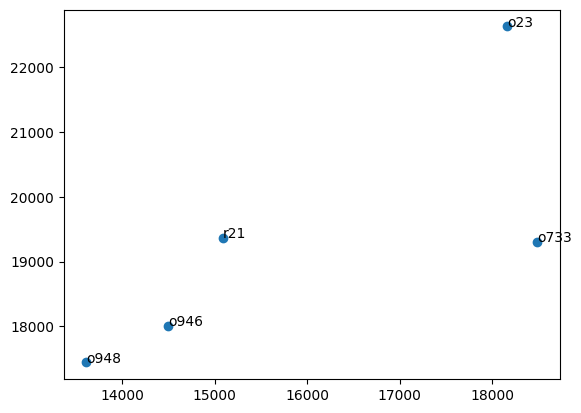

In [141]:
# Plot chart
import matplotlib.pyplot as plt
x = [locations.at['r21','x'],locations.at['o946','x'],locations.at['o948','x'],locations.at['o733','x'],locations.at['o23','x']]
y = [locations.at['r21','y'],locations.at['o946','y'],locations.at['o948','y'],locations.at['o733','y'],locations.at['o23','y']]
lable = ['r21','o946', 'o948', 'o733', 'o23']
for i, txt in enumerate(lable):
    plt.annotate(txt, (x[i], y[i]))
plt.scatter(x, y)
plt.show()